# 1. Install and Import Dependencies

https://youtu.be/vahwuupy81A

In [58]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [59]:
# !pip install stable-baselines3[extra] protobuf==3.20.*

In [60]:
# !pip install mss pydirectinput pytesseract

In [61]:
#chrome://dino/

In [62]:
# MSS for screen cap
from mss import mss

# sending commands
import pydirectinput

# Opencv allows us to do frame processing
import cv2

# transformational framework
import numpy as np

# OCR for game over extraction
import pytesseract

# visualize captured frames
from matplotlib import pyplot as plt

# bring in time for pauses
import time

# create environment
from gym import Env
from gym.spaces import Box, Discrete

# 2. Build the Environment

## 2.1 Create Environment

In [63]:
class WebGame(Env):
    """
    Webgame dev

    """
    def __init__(self):
        """
        Setup the environment, action and observation space
        """
        super().__init__()
        
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        
        # Capture game frames
        self.cap = mss()
        # needs to be adjusted later on
        self.game_location = {'top': 630, 'left': 0, 'width': 800, 'height': 400}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

# 2.2 Test Environment

In [64]:
env = WebGame()

In [65]:
obs=env.get_observation()

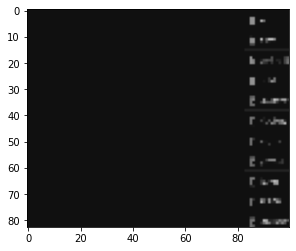

In [66]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [67]:
done, done_cap = env.get_done()

TesseractError: (1, 'Error opening data file C:\\Users\\Lennart Luttkus\\anaconda3\\envs\\rl-test\\Library\\bin/tessdata/eng.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'eng\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')

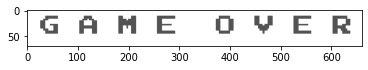

In [51]:
plt.imshow(done_cap)

In [52]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [53]:
done

True

In [54]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

Total Reward for episode 0 is 16
Total Reward for episode 1 is 15
Total Reward for episode 2 is 13
Total Reward for episode 3 is 13
Total Reward for episode 4 is 13
Total Reward for episode 5 is 13
Total Reward for episode 6 is 14
Total Reward for episode 7 is 11
Total Reward for episode 8 is 13
Total Reward for episode 9 is 15


# 3. Train the Model

## 3.1 Create Callback

In [55]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [56]:
env_checker.check_env(env)

In [57]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [58]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [59]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [60]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [61]:
env = WebGame()

In [62]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=100000, callback=callback)

In [ ]:
model.load('train_first/best_mode l_50000') 

# 4. Test out Model

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)